In [1]:
from time import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from skimage.morphology import label
from scipy.ndimage import measurements
import itertools

In [2]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:18]))))

# First steps to do the pentomino filling and work out the score.
# Pentomino code modified from here https://www.reddit.com/r/dailyprogrammer/comments/8t4440/20180622_challenge_364_hard_tiling_with_pentominos/
#
# How to move to actually getting the optimum score is a much harder question

### 'Pent-up' Frustration

Place as many distinct pentominoes as you want into an 8-by-8 grid, in such a
way that the placement is “tight” — i.e., no piece(s) can freely slide around
within the grid.
The score for a given placement is the
sum of the square roots of the areas of
the empty regions
in the grid.
What is the largest score you can obtain?
This month, when you send in your entry, please send in your grid. Please use
the
standard
notation
, — i.e. F,
I, L, N, P, T, U, V, W, X, Y, Z — and use “.” to denote empty spaces. (So the
top row in the valid placement example would be “…Z..LL”)

<img src='https://www.janestreet.com/puzzles/20181101_pent-up.png' width =300>

In [3]:


def reset(positions):
    min_x, min_y = min(positions, key=lambda x:x[::-1])
    return tuple(sorted((x-min_x, y-min_y) for x, y in positions))

def variation(positions):
    return list({reset(var) for var in (
        positions,
        [(-y,  x) for x, y in positions], # Anti-clockwise 90
        [(-x, -y) for x, y in positions], # 180
        [( y, -x) for x, y in positions], # Clockwise 90

        [(-x,  y) for x, y in positions], # Mirror vertical
        [(-y, -x) for x, y in positions], # Mirror diagonal
        [( x, -y) for x, y in positions], # Mirror horizontal
    )})

shapes = [
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 0)), "F"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)), "I"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (1, 3)), "L"),
    (((0, 2), (0, 3), (1, 0), (1, 1), (1, 2)), "N"),
    (((0, 0), (0, 1), (0, 2), (1, 0), (1, 1)), "P"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 0)), "T"),
    (((0, 0), (0, 1), (1, 1), (2, 0), (2, 1)), "U"),
    (((0, 0), (0, 1), (0, 2), (1, 2), (2, 2)), "V"),
    (((0, 0), (0, 1), (1, 1), (1, 2), (2, 2)), "W"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 1)), "X"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (1, 3)), "Y"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 2)), "Z")
]

shape_variations = {shape: variation(shape) for shape, name in shapes}

def pprint(grid, size):
    width, height = size

    out= np.array([[ grid[x,y] for y in range(width)] for x in range(height)])
    shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    mapping = np.vectorize(lambda x:shapes.index(x))
    shading = mapping(out)
    
    fig,axs = plt.subplots(1,1,figsize =(width/2,height/2))
    axs = sns.heatmap(shading,annot=out,cbar=False,cmap="terrain_r",fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey')
    axs.axis("off")
    plt.show()
    
    labels, num = measurements.label(out == ' ',output=int)
    areas = measurements.sum(out == ' ', labels, index=range(1, num+1))
    print("The areas are:{} giving {:.3f} as a solution".format(areas,np.sum(areas**.5)))

def solve(grid, size, available_shapes, start=0):
    width, height = size

    # Traverse the grid left to right, then top to bottom like reading a book
    # Look for next open space (".")
    for i in range(start, width*height):
        y, x = divmod(i, width)
        if grid[(x, y)] == ".":
            for shape, name in available_shapes:
                # Check each rotation and reflection of shape
                for shape_var in shape_variations[shape]:
                    if all(grid.get((x+xs, y+ys)) == "." for xs, ys in shape_var):
                        temp_grid = grid.copy()
                        temp_shapes = available_shapes.copy()
                        for xs, ys in shape_var:
                            temp_grid[(x+xs, y+ys)] = name
                        temp_shapes.remove((shape, name))

                        yield from solve(temp_grid, size, temp_shapes, i+1)
            
            return # No more shapes are found, let previous recursion continue
    # yield final grid when all grid values have been checked
    yield grid

def main(width, height, *holes):
    t = time()
    #print(width, height, *holes)

    grid = {(x, y): "." for x in range(width) for y in range(height)}
    for x, y in holes:
        grid[(x, y)] = " "

    for solution in solve(grid, (width, height), shapes):
        pprint(solution, (width, height))
        break
    else:
        print("No solution")
    print("Took {:.3f} seconds".format(time()-t))
    

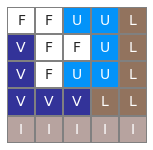

The areas are:[] giving 0.000 as a solution
Took 0.094 seconds


In [4]:
main(5, 5)

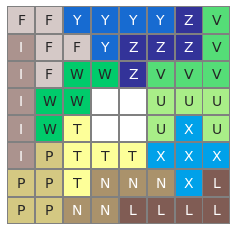

The areas are:[4.] giving 2.000 as a solution
Took 0.313 seconds


In [5]:
main(8, 8, (3, 3), (4, 3), (3, 4), (4, 4))

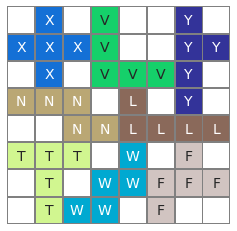

The areas are:[1. 1. 4. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2.] giving 19.657 as a solution
Took 0.204 seconds


In [6]:
# Given the empty squares the code will place the pentiominos correctly and get the right score

solved = [(0,0),(0,2),(0,4),(0,5),(0,7),
 (1,4),(1,5),
 (2,0),(2,2),(2,7),
 (3,3),(3,5),(3,7),
 (4,0),(4,1),
 (5,3),(5,5),(5,7),
 (6,0),(6,2),
 (7,0),(7,4),(7,6),(7,7)]

main(8, 8,*solved)

In [7]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

### November 2018 : Solution

The highest-scoring configuration is shown here, scoring 14 + 4*sqrt(2), or
about
19.66
points.
The top 31-scoring entries we received all used exactly 8 pentominos; the
highest-scoring entry to use a different number of pentominos was 17.83 (which
used 9).

<img src="https://www.janestreet.com/puzzles/20181203_pent-up_ans.png" width = 200>